# Gaussian kernel density estimation

The provided function `gaussian_kde_gpu()` is a simplified version of Scipy's `gaussian_kde`. It does not support weights and only uses the default Scott's Rule for bandwidth estimation. However, it leverages the computative power of a CUDA supported GPU via Numba.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from time import time

from scipy.stats import gaussian_kde
from gaussian_kde_gpu import gaussian_kde_gpu

Here we will estimate densities from samples of multivariate normal distributions so that we can compare results to theoretical PDFs:

In [2]:
def pdf_normal(x, scale):
    """Ground truth, theoretical multivariate normal distribution."""
    d = x.shape[1]
    assert d == len(scale), "dimension mismatch"
    H = np.eye(d) * np.array(scale)
    H *= H
    Hinv = np.linalg.inv(H)
    f = (2 * np.pi) ** (-d / 2)
    f /= np.sqrt(np.linalg.det(H))
    return f * np.exp(-0.5 * np.sum(x.dot(Hinv) * x, axis=-1))

In this first example we focus on the 2D case of a multivariate normal distribution with standard deviation 0.75 along the x-axis and 1.5 along the y-axis. The two dimensions are independent. We draw 65536 samples from that distribution and evaluate our kernel density estimation on half as many points in the plane $x, y \in [-1, 1)$.

In [3]:
# number of samples from which we estimate the PDF
n = 65536

# different STDs for the multivariate Gaussian
scale = (0.75, 1.5)

# dimension
d = len(scale)

# the actual samples / random variable
p = np.random.normal(scale=scale, size=(n, d))

# we evaluate the PDF at query points q
m = n // 2
q = (np.random.random((m, d)) - 0.5) * 2

# theoretical PDF (truth)
theory = pdf_normal(q, scale=scale)

# our density estimation
p_gpu = gaussian_kde_gpu(p, q)

In [4]:
# SciPy's density estimation
kde = gaussian_kde(p.T)
p_spy = kde(q.T)

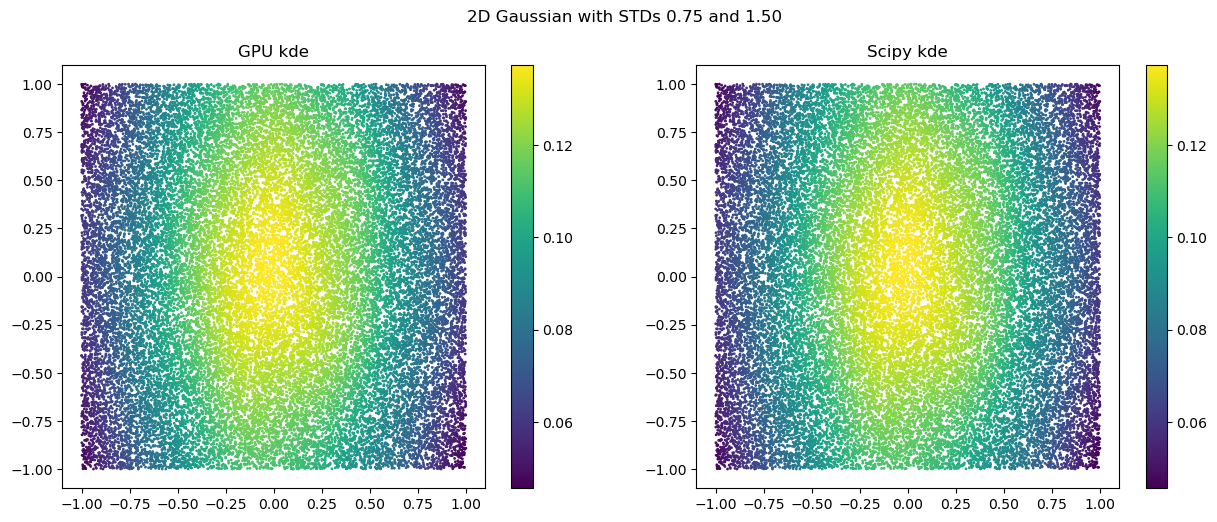

In [5]:
fg, ax = pl.subplots(1, 2, figsize=(15, 5.5))
pl.suptitle("2D Gaussian with STDs %.2f and %.2f" % (scale[0], scale[1]))
ax[0].set_title("GPU kde")
im = ax[0].scatter(q[:, 0], q[:, 1], s=1, c=p_gpu)
fg.colorbar(im, ax=ax[0])
ax[1].set_title("Scipy kde")
im = ax[1].scatter(q[:, 0], q[:, 1], s=1, c=p_spy)
fg.colorbar(im, ax=ax[1])
pl.show()

We can also compare estimates to theoretical results and estimates within itself in a scatter plots.

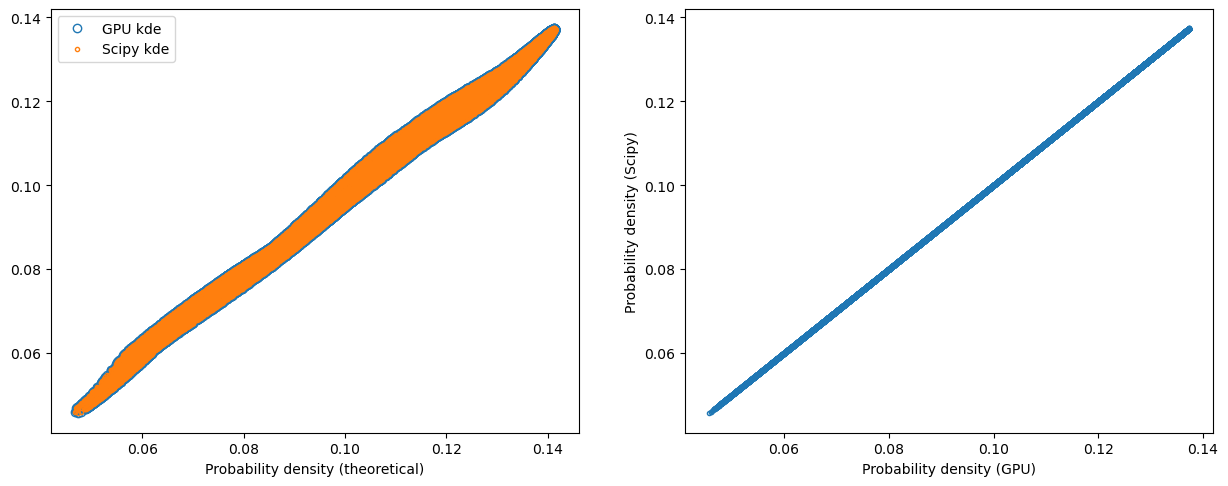

In [6]:
fg, ax = pl.subplots(1, 2, figsize=(15, 5.5))
ax[0].plot(theory, p_gpu, "o", mfc="none", label="GPU kde")
ax[0].plot(theory, p_spy, ".", mfc="none", label="Scipy kde")
ax[0].set_xlabel("Probability density (estimates)")
ax[0].set_xlabel("Probability density (theoretical)")
ax[0].legend()
ax[1].plot(p_gpu, p_spy, ".", mfc="none")
ax[1].set_xlabel("Probability density (GPU)")
ax[1].set_ylabel("Probability density (Scipy)")
pl.show()

The whole point of this execise is to speed up computations. In order to measure run times and speed up factors, we increase the workload for this second example a bit. On one hand we sample and estimate 3D distributions, and on the other hand we evaluate estimations on as many points as we have samples (n == m). This will produce an approximate quadratic scaling. Hence, with twice as many samples the run times will be four times as long. In order to emphasize this, we pick sample sizes as powers of two. 

In [7]:
# log2 space
jr = np.cumprod(np.ones(20)*2).astype(int)
jr = jr[11:]

n = jr[-1]
scale = (0.75, 1.5, 1)
d = len(scale)
p = np.random.normal(scale=scale, size=(n, d))
q = (np.random.random((n, d)) - 0.5) * 2

run_times = np.zeros((len(jr), 2))
for i, j in enumerate(jr):
    t = time()
    r = gaussian_kde_gpu(p[:j], q[:j], threadsperblock=128)
    run_times[i, 0] = time() - t
    print(run_times[i, 0])

/home/aljoscha/miniconda3/envs/numba/lib/python3.11/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/aljoscha/miniconda3/envs/numba/lib/python3.11/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0.007323026657104492
0.014357805252075195
0.03969907760620117
0.14719796180725098
0.5500075817108154
2.192856550216675
8.799372673034668
34.93003797531128
142.01187920570374


In [8]:
for i, j in enumerate(jr[:7]):
    t = time()
    kde = gaussian_kde(p[:j].T)
    r = kde(q[:j].T)
    run_times[i, 1] = time() - t
    print(run_times[i, 1])

0.08147144317626953
0.3069722652435303
1.2128632068634033
4.84488320350647
19.350460529327393
77.38853240013123
309.2649037837982


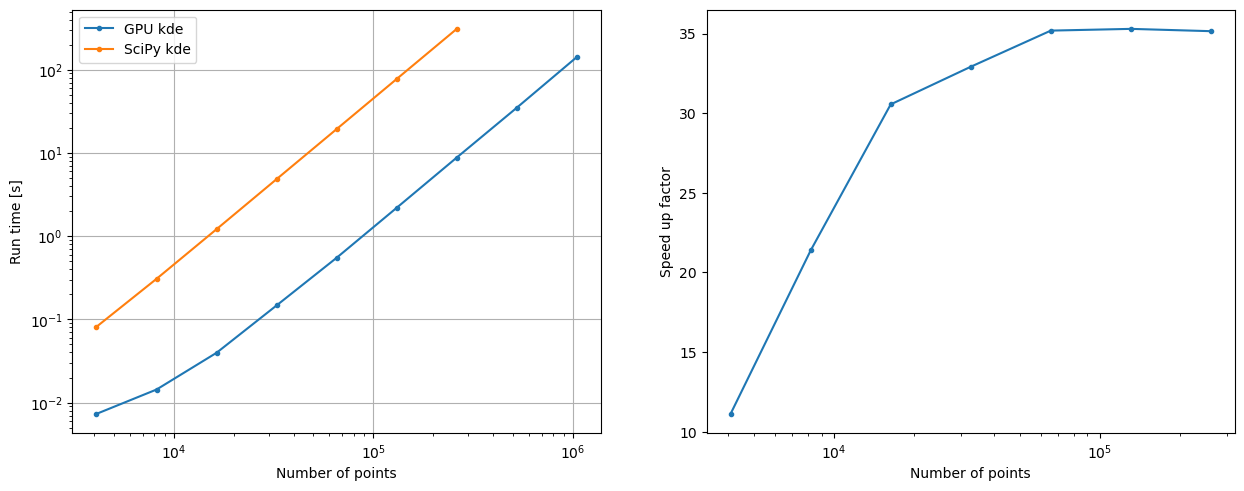

In [9]:
fg, ax = pl.subplots(1, 2, figsize=(15, 5.5))
ax[0].loglog(jr, run_times[:, 0], '.-', label="GPU kde")
ax[0].loglog(jr[:7], run_times[:7, 1], '.-', label="SciPy kde")
ax[0].legend()
ax[0].grid()
ax[0].set_xlabel("Number of points")
ax[0].set_ylabel("Run time [s]")
ax[1].semilogx(jr[:7], run_times[:7, 1] / run_times[:7, 0], '.-')
ax[1].set_xlabel("Number of points")
ax[1].set_ylabel("Speed up factor")
pl.show()